In [1]:
!nvidia-smi

Wed Apr  9 07:25:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import gdown # to download dataset file from drive
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import random
import h5py

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import os
random.seed(0) # for validation

import time # measure training time
from scipy.signal import find_peaks
# Model archicture

import tensorflow as tf
import keras
from keras import backend as K

In [3]:
def find_max_min(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)

    return arr_min, arr_max

def to_timeseries(X, y, is_train, max_len):
    """
    Generate data for each sample.
    X: Input data with shape (625, 2)
    y: Target data with shape (625)
    is_train: Boolean indicating if the data is for training (used for different normalization)
    max_len: Length of the time series window
    """
    seq_x = []
    seqs_x = []
    seqs_y = []
    seq_y = []

    min_max = np.load(data_path+'min_max.npy')
    min_max_train = np.load(data_path+'min_max_train.npy')

    ppg_all_min, ppg_all_max = min_max[0]
    ecg_all_min, ecg_all_max = min_max[1]
    abp_all_min, abp_all_max = min_max[2]

    ppg_train_min, ppg_train_max = min_max_train[0]
    ecg_train_min, ecg_train_max = min_max_train[1]
    abp_train_min, abp_train_max = min_max_train[2]

    # Iterate over the 625 data points in each sample
    for i in range(X.shape[0]):
        if len(seq_x) < max_len:
            if is_train:
                seq_x.append([
                    (X[i, 0] - ppg_train_min) / (ppg_train_max - ppg_train_min),
                    (X[i, 1] - ecg_train_min) / (ecg_train_max - ecg_train_min)
                ])
                seq_y.append([(y[i] - abp_train_min) / (abp_train_max - abp_train_min)])
            else:
                seq_x.append([
                    (X[i, 0] - ppg_all_min) / (ppg_all_max - ppg_all_min),
                    (X[i, 1] - ecg_all_min) / (ecg_all_max - ecg_all_min)
                ])
                seq_y.append([(y[i] - abp_all_min) / (abp_all_max - abp_all_min)])
        else:
            seq_x = seq_x[1:]
            seq_y = seq_y[1:]
            if is_train:
                seq_x.append([
                    (X[i, 0] - ppg_train_min) / (ppg_train_max - ppg_train_min),
                    (X[i, 1] - ecg_train_min) / (ecg_train_max - ecg_train_min)
                ])
                seq_y.append([(y[i] - abp_train_min) / (abp_train_max - abp_train_min)])
            else:
                seq_x.append([
                    (X[i, 0] - ppg_all_min) / (ppg_all_max - ppg_all_min),
                    (X[i, 1] - ecg_all_min) / (ecg_all_max - ecg_all_min)
                ])
                seq_y.append([(y[i] - abp_all_min) / (abp_all_max - abp_all_min)])

        if len(seq_x) < max_len:
            continue
        else:
            seqs_x.append(seq_x.copy())  # Ensure a copy is made
            seqs_y.append(seq_y.copy())

    zeros_y = np.zeros((len(seqs_y), max_len, 1))
    return seqs_x, zeros_y, seqs_y



def find_abp_peak_sys(abp, delay):
    index_max_abp = []
    loop_count = int(len(abp)/delay)
    index = 0
    for i in range(loop_count):
        max_value = 0
        max_index = 0
        for j in abp[i*delay:(i+1)*delay]:
            if j > max_value:
                max_value = j
                max_index = index

            index = index + 1
        index_max_abp.append(max_index)

    return index_max_abp

def find_abp_peak_dia(abp, delay):
    index_min_abp = []
    loop_count = int(len(abp)/delay)
    index = 0
    for i in range(loop_count):
        min_value = 9999999999
        min_index = 0
        for j in abp[i*delay:(i+1)*delay]:
            if j < min_value:
                min_value = j
                min_index = index
            index = index + 1

        index_min_abp.append(min_index)

    return index_min_abp

def zero_order_holding_first(abp, delay, is_sys):
    if is_sys:
        index_max_abp = find_abp_peak_sys(abp, delay)
    else:
        index_max_abp = find_abp_peak_dia(abp, delay)

    peak_abp = np.zeros(len(abp))
    j = 0
    for i in range(len(abp)):
        if i < index_max_abp[j]:
            if j == 1:
                peak_abp[i] = abp[index_max_abp[0]]
            else:
                peak_abp[i] = abp[index_max_abp[j-1]]
        else:
            j = j + 1
            if j >= len(index_max_abp):
                j = j - 1
            if j == 1:
                peak_abp[i] = abp[index_max_abp[0]]
            else:
                peak_abp[i] = abp[index_max_abp[j-1]]

    return peak_abp

def zero_order_second(signal):
    change = 0
    num = len(signal)
    for i in range(0, num-10):
        counter = 0
        if signal[i+1] != signal[i]:
            change = 1
            for j in range(1, 12):
                if signal[i+j] == signal[i]:
                    counter = counter + 1
        if change == 1 and counter > 0:
            for j in range(0, 11):
                signal[i+j] = signal[i]
        change = 0
    return signal

def bhs_grades(errors):
    """
    Compute BHS grading based on SBP/DBP errors.
    :param errors: Array of absolute errors (SBP or DBP).
    :return: BHS grading (A, B, C, or Fail).
    """
    errors = np.abs(np.array(errors).flatten())
    within_5 = np.mean(errors <= 5) * 100
    within_10 = np.mean(errors <= 10) * 100
    within_15 = np.mean(errors <= 15) * 100

    print(f"Within 5 mmHg: {within_5:.2f}%")
    print(f"Within 10 mmHg: {within_10:.2f}%")
    print(f"Within 15 mmHg: {within_15:.2f}%")
    print()

    if within_5 >= 60 and within_10 >= 85 and within_15 >= 95:
        return "A"
    elif within_5 >= 50 and within_10 >= 75 and within_15 >= 90:
        return "B"
    elif within_5 >= 40 and within_10 >= 65 and within_15 >= 85:
        return "C"
    else:
        return "Fail"

def calculate_error_metrics(y_true, y_pred):
    """
    Calculate MAE, RMSE, and ME ± SD for SBP and DBP.
    :param y_true: 1D array of true values (SBP or DBP).
    :param y_pred: 1D array of predicted values (SBP or DBP).
    :return: MAE, RMSE, ME ± SD (Mean Error and Standard Deviation of error).
    """

    y_true = np.array(y_true)  # Convert to NumPy array
    y_pred = np.array(y_pred)  # Convert to NumPy array
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_error = np.mean(y_pred - y_true)
    std_error = np.std(y_pred - y_true)

    return mae, rmse, mean_error, std_error


def accumulate_episodes(data, signal_type):
    """
    Accumulate episodes from all records into a single dataset, ensuring uniform length.

    Parameters:
    - data (dict): Filtered dataset (e.g., butterworth_data).
    - signal_type (str): Type of signal to accumulate ('filtered_ecg' or 'filtered_abp').

    Returns:
    - accumulated_data (np.array): Array of shape (total_episodes, 625).
    """
    accumulated_data = []

    for record_id in data.keys():  # Loop through each record
        for episode in data[record_id][signal_type]:  # Loop through each 10-second episode
            if len(episode) == 625:  # Ensure the episode has 625 points
                accumulated_data.append(episode)  # Add the episode to the list
            #else:
                #print(f"Skipping episode with invalid length: {len(episode)} (Record: {record_id})")

    return np.array(accumulated_data)  # Convert list to numpy array

In [4]:
from tensorflow.keras import backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def create_model():

    keras.backend.clear_session()

    layers = [128, 128]  # Number of hidden neurons in each layer of the encoder and decoder

    optimiser = keras.optimizers.Adam(learning_rate=0.001)  # No decay parameter

    num_input_features = 2  # The dimensionality of the input at each time step. In this case a 1D signal.
    num_output_features = 1  # The dimensionality of the output at each time step. In this case a 1D signal.

    loss = rmse  # Root Mean Squared Error loss function

    lambda_regulariser = 0.000001  # Regularization parameter
    regulariser = None  # No regularization used in this example

    # Define the encoder input layer
    encoder_inputs = keras.layers.Input(shape=(None, num_input_features))

    # Create LSTM cells for the encoder
    encoder_cells = []
    for hidden_neurons in layers:
        encoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                                  kernel_regularizer=regulariser,
                                                  recurrent_regularizer=regulariser,
                                                  bias_regularizer=regulariser))

    # Create the encoder RNN layer
    encoder = keras.layers.RNN(encoder_cells, return_state=True)

    # Get encoder outputs and states
    encoder_outputs_and_states = encoder(encoder_inputs)

    # Keep only the states, discard the encoder outputs
    encoder_states = encoder_outputs_and_states[1:]

    # Define the decoder input layer
    decoder_inputs = keras.layers.Input(shape=(None, 1))

    # Create LSTM cells for the decoder
    decoder_cells = []
    for hidden_neurons in layers:
        decoder_cells.append(keras.layers.LSTMCell(hidden_neurons,
                                                  kernel_regularizer=regulariser,
                                                  recurrent_regularizer=regulariser,
                                                  bias_regularizer=regulariser))

    # Create the decoder RNN layer
    decoder = keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

    # Set the initial state of the decoder to be the output state of the encoder
    decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

    # Only select the decoder outputs (not the states)
    decoder_outputs = decoder_outputs_and_states[0]

    # Apply a dense layer with linear activation to set output to correct dimension
    decoder_dense = keras.layers.Dense(num_output_features,
                                       activation='linear',
                                       kernel_regularizer=regulariser,
                                       bias_regularizer=regulariser)

    # Final output of the model
    decoder_outputs = decoder_dense(decoder_outputs)

    # Create the Keras model
    model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

    # Compile the model with Adam optimizer and RMSE loss
    model.compile(optimizer=optimiser, loss=loss, metrics=['mae'])

    return model

In [5]:
file_id = "12KmtjeVHuZP4omk-AvEBpfwmI1cPn1R7"
download_url = f"https://drive.google.com/uc?id={file_id}"
output_file = "butter_maf_dataset.npy"

gdown.download(download_url, output_file, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=12KmtjeVHuZP4omk-AvEBpfwmI1cPn1R7
From (redirected): https://drive.google.com/uc?id=12KmtjeVHuZP4omk-AvEBpfwmI1cPn1R7&confirm=t&uuid=347755e7-5c14-43f6-847c-ae1e80a13f9a
To: /kaggle/working/butter_maf_dataset.npy
100%|██████████| 384M/384M [00:04<00:00, 79.1MB/s] 


'butter_maf_dataset.npy'

In [6]:
bm_data = np.load("butter_maf_dataset.npy", allow_pickle=True).item()

ppg_bm = accumulate_episodes(bm_data, signal_type='filtered_ppg')
ecg_bm = accumulate_episodes(bm_data, signal_type='filtered_ecg')
abp_bm = accumulate_episodes(bm_data, signal_type='filtered_abp')

print(f"Shapes of PPG: {ppg_bm.shape}")
print(f"Shapes of ECG: {ecg_bm.shape}")
print(f"Shapes of ABP: {abp_bm.shape}")

Shapes of PPG: (25319, 625)
Shapes of ECG: (25319, 625)
Shapes of ABP: (25319, 625)


In [7]:
ecg_all_min, ecg_all_max = find_max_min(ecg_bm)
ppg_all_min, ppg_all_max = find_max_min(ppg_bm)
abp_all_min, abp_all_max = find_max_min(abp_bm)

print(f"Min-Max ECG: {ecg_all_min}, {ecg_all_max}")
print(f"Min-Max PPG: {ppg_all_min}, {ppg_all_max}")
print(f"Min-Max ABP: {abp_all_min}, {abp_all_max}")

Min-Max ECG: -6.654543363624855, 5.95138071904283
Min-Max PPG: -0.4319849228423467, 1.3683320489575586
Min-Max ABP: 56.703305503654256, 178.33897786460318


In [8]:
!mkdir data_bm

data_path = 'data_bm/'

np.save(data_path+'min_max.npy', np.array([
    [ppg_all_min, ppg_all_max],
    [ecg_all_min, ecg_all_max],
    [abp_all_min, abp_all_max]
]), allow_pickle=True)

In [9]:
X = np.stack((ppg_bm, ecg_bm), axis=2)

# Assign ABP to y
y = abp_bm

# Output the shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (25319, 625, 2)
y shape: (25319, 625)


In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_val_ppg = X_train_val[:, :, 0:1]
X_train_val_ecg = X_train_val[:, :, 0:2]

ppg_train_min, ppg_train_max = find_max_min(X_train_val_ppg)
ecg_train_min, ecg_train_max = find_max_min(X_train_val_ecg)
abp_train_min, abp_train_max = find_max_min(y_train_val)

np.save(data_path+'min_max_train.npy', np.array([
    [ppg_train_min, ppg_train_max],
    [ecg_train_min, ecg_train_max],
    [abp_train_min, abp_train_max]
]), allow_pickle=True)

In [11]:
batch_size = 512
epochs = 50
timewindow = 32

In [12]:
# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print('Num of training samples:', X_train.shape[0])
print('Num of validation samples:', X_valid.shape[0])
print('-' * 30)

# Convert the training set to time series
encoder_input, decoder_output, decoder_input = [], [], []
print('Start converting training set to timeseries...')
for i in range(X_train.shape[0]):

    s_x, z_y, s_y = to_timeseries(X_train[i], y_train[i], is_train=True, max_len=timewindow)
    encoder_input.extend(s_x)
    decoder_output.extend(s_y)
    decoder_input.extend(z_y)
encoder_input, decoder_output, decoder_input = map(np.array, [encoder_input, decoder_output, decoder_input])
print('Done converting training set to timeseries...')
print('Num of sequences:', encoder_input.shape[0])
print('-' * 30)

# Convert the validation set to time series
encoder_input_valid, decoder_output_valid, decoder_input_valid = [], [], []
print('Start converting validation set to timeseries...')
for i in range(X_valid.shape[0]):
    s_x, z_y, s_y = to_timeseries(X_valid[i], y_valid[i], is_train=False, max_len=timewindow)
    encoder_input_valid.extend(s_x)
    decoder_output_valid.extend(s_y)
    decoder_input_valid.extend(z_y)
encoder_input_valid, decoder_output_valid, decoder_input_valid = map(np.array, [encoder_input_valid, decoder_output_valid, decoder_input_valid])
print('Done converting validation set to timeseries...')
print('Num of sequences:', encoder_input_valid.shape[0])
print('=' * 30)

Num of training samples: 16204
Num of validation samples: 4051
------------------------------
Start converting training set to timeseries...
Done converting training set to timeseries...
Num of sequences: 9625176
------------------------------
Start converting validation set to timeseries...
Done converting validation set to timeseries...
Num of sequences: 2406294


#### The data is splitted and trained in half to solve the RAM limitations in Kaggle 

In [13]:
split_idx = encoder_input.shape[0] // 2  # Get halfway index

# First half
encoder_input_1, decoder_output_1, decoder_input_1 = (
    encoder_input[:split_idx], decoder_output[:split_idx], decoder_input[:split_idx]
)

# Second half
encoder_input_2, decoder_output_2, decoder_input_2 = (
    encoder_input[split_idx:], decoder_output[split_idx:], decoder_input[split_idx:]
)

print(encoder_input_1.shape)
print(decoder_output_1.shape)
print(decoder_input_1.shape)
print(encoder_input_2.shape)
print(decoder_output_2.shape)
print(decoder_input_2.shape)

(4812588, 32, 2)
(4812588, 32, 1)
(4812588, 32, 1)
(4812588, 32, 2)
(4812588, 32, 1)
(4812588, 32, 1)


In [14]:
# Step 1: Create and Train the Model on First Part
model = create_model()  # Ensure create_model() gives the same architecture
history_1 = model.fit(
    [encoder_input_1, decoder_input_1], decoder_output_1,
    validation_data=([encoder_input_valid, decoder_input_valid], decoder_output_valid),
    batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1
)

# Step 2: Save the Full Model (including weights & optimizer state)
model.save("model_half1.h5")

model = tf.keras.models.load_model("model_half1.h5", custom_objects={"rmse": rmse})

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss="mse", 
              metrics=[rmse])

history_2 = model.fit(
    [encoder_input_2, decoder_input_2], decoder_output_2,
    validation_data=([encoder_input_valid, decoder_input_valid], decoder_output_valid),
    batch_size=batch_size, epochs=epochs, shuffle=True, verbose=1)

Epoch 1/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 280s 29ms/step - loss: 0.1026 - mae: 0.0753 - val_loss: 0.0611 - val_mae: 0.0467
Epoch 2/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 264s 28ms/step - loss: 0.0593 - mae: 0.0408 - val_loss: 0.0489 - val_mae: 0.0375
Epoch 3/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 264s 28ms/step - loss: 0.0523 - mae: 0.0358 - val_loss: 0.0471 - val_mae: 0.0358
Epoch 4/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 264s 28ms/step - loss: 0.0487 - mae: 0.0332 - val_loss: 0.0443 - val_mae: 0.0337
Epoch 5/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 264s 28ms/step - loss: 0.0462 - mae: 0.0315 - val_loss: 0.0433 - val_mae: 0.0329
Epoch 6/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 264s 28ms/step - loss: 0.0444 - mae: 0.0303 - val_loss: 0.0420 - val_mae: 0.0318
Epoch 7/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 264s 28ms/step - loss: 0.0431 - mae: 0.0294 - val_loss: 0.0414 - val_mae: 0.0313
Epoch 8/50
9400/9400 ━━━━━━━━━━━━━━━━━━━━ 264s 28ms/step - loss: 0.0420 - mae: 0.0286 - val_loss: 0.0410 - val_mae: 0.0310
Epoch 9/50
9400/

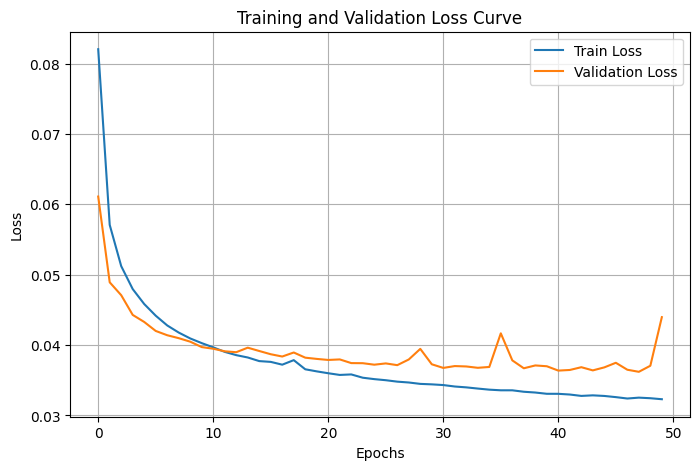

In [15]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

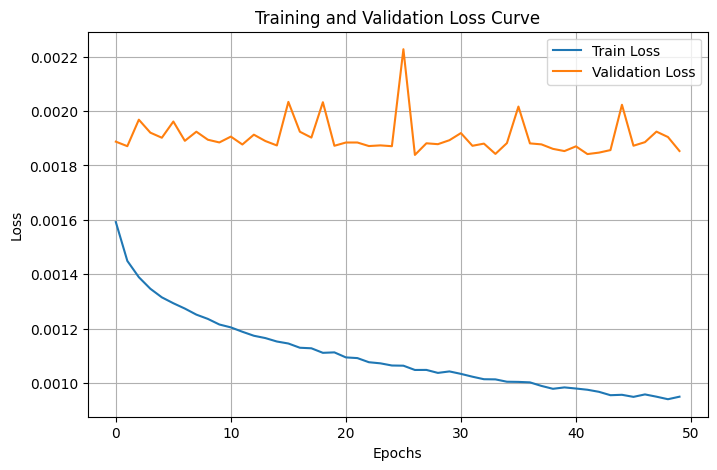

In [16]:
# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
pred_sys_ls = []
gt_sys_ls = []

pred_dia_ls = []
gt_dia_ls = []

pred_abp_ls = []
gt_abp_ls = []


# Iterate over the test data (looping over multiple subjects)
for i in range(X_test.shape[0]):
    # Get timeseries for current test subject
    test_x, test_zeros, _ = to_timeseries(X_test[i], y_test[i], is_train=False, max_len=timewindow)
    ground_truth_x, _, ground_truth_y = to_timeseries(X_test[i], y_test[i], is_train=False, max_len=timewindow)

    # Make prediction using the model
    y_test_predicted = model.predict([np.array(test_x), test_zeros], batch_size=batch_size)

    p_abp = []
    g_abp = []

    # Process predicted and ground truth values for current subject
    for j in range(y_test_predicted.shape[0]):
        # Append predicted ABP
        p_abp.append(y_test_predicted[j][-1][0] * (abp_all_max - abp_all_min) + abp_all_min)

        # Append ground truth ABP (account for possible nested lists)
        if isinstance(ground_truth_y[j][-1], list):  # Check if it's a nested list
            g_abp.append(ground_truth_y[j][-1][0] * (abp_all_max - abp_all_min) + abp_all_min)
        else:  # It's a single value
            g_abp.append(ground_truth_y[j][-1] * (abp_all_max - abp_all_min) + abp_all_min)

    # Post-process predicted and ground truth ABP for systolic and diastolic values
    p_sys = zero_order_holding_first(p_abp, delay=100, is_sys=True)
    g_sys = zero_order_holding_first(g_abp, delay=100, is_sys=True)
    p_dia = zero_order_holding_first(p_abp, delay=100, is_sys=False)
    g_dia = zero_order_holding_first(g_abp, delay=100, is_sys=False)

    # Further processing of systolic and diastolic values
    p_sys = zero_order_second(p_sys)
    g_sys = zero_order_second(g_sys)
    p_dia = zero_order_second(p_dia)
    g_dia = zero_order_second(g_dia)

    # Store results for current subject
    pred_sys_ls.extend(p_sys)
    gt_sys_ls.extend(g_sys)
    pred_dia_ls.extend(p_dia)
    gt_dia_ls.extend(g_dia)

    pred_abp_ls.extend(p_abp)
    gt_abp_ls.extend(g_abp)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 985ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━

In [20]:
# Error calculation for MAP continious BP
pred_all_continuous = np.array(pred_abp_ls)
true_all_continuous = np.array(gt_abp_ls)

# Compute Error Metrics
errors = np.abs(pred_all_continuous - true_all_continuous)
mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors ** 2))

# Compute ME (Mean Error) and SD (Standard Deviation)
me = np.mean(errors)
sd = np.std(errors)
bhs_map = bhs_grades(errors)

print(f"Final MAE (unscaled): {mae:.4f}, Final RMSE: {rmse:.4f}")
print(f"Mean Error (ME): {me:.4f} ± {sd:.4f} (SD) unscaled")
print(f"BHS grade: {bhs_map}")

Within 5 mmHg: 84.06%
Within 10 mmHg: 95.97%
Within 15 mmHg: 98.38%

Final MAE (unscaled): 3.0225, Final RMSE: 5.0150
Mean Error (ME): 3.0225 ± 4.0019 (SD) unscaled
BHS grade: A


In [21]:
# Compute overall metrics after all subjects have been processed
mae_sys_all, rmse_sys_all, me_sys, sd_sys = calculate_error_metrics(gt_sys_ls, pred_sys_ls)
mae_dia_all, rmse_dia_all, me_dia, sd_dia = calculate_error_metrics(gt_dia_ls, pred_dia_ls)

# Compute BHS grades
bhs_grade_sys = bhs_grades(np.array(pred_sys_ls) - np.array(gt_sys_ls))
bhs_grade_dia = bhs_grades(np.array(pred_dia_ls) - np.array(gt_dia_ls))

# Print overall performance metrics
print(f"Overall RMSE for Systolic BP: {rmse_sys_all:.2f}")
print(f"Overall RMSE for Diastolic BP: {rmse_dia_all:.2f}")
print(f"Overall MAE for Systolic BP: {mae_sys_all:.2f}")
print(f"Overall MAE for Diastolic BP: {mae_dia_all:.2f}")
print()
# Print Mean Error ± Standard Deviation
print(f"Systolic BP ME ± SD: {me_sys:.2f} ± {sd_sys:.2f}")
print(f"Diastolic BP ME ± SD: {me_dia:.2f} ± {sd_dia:.2f}")
print()
# Print BHS Grading
print(f"BHS Grade for Systolic BP: {bhs_grade_sys}")
print(f"BHS Grade for Diastolic BP: {bhs_grade_dia}")

Within 5 mmHg: 74.00%
Within 10 mmHg: 93.30%
Within 15 mmHg: 97.33%

Within 5 mmHg: 91.52%
Within 10 mmHg: 97.74%
Within 15 mmHg: 99.01%

Overall RMSE for Systolic BP: 6.26
Overall RMSE for Diastolic BP: 4.16
Overall MAE for Systolic BP: 4.03
Overall MAE for Diastolic BP: 2.27

Systolic BP ME ± SD: 0.94 ± 6.19
Diastolic BP ME ± SD: -0.62 ± 4.12

BHS Grade for Systolic BP: A
BHS Grade for Diastolic BP: A
